In [8]:
# Import libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage import filters
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Paths to dataset
first_print_zip = r"C:\Users\jhasn\Downloads\First Print-20250323T191627Z-001.zip"
second_print_zip = r"C:\Users\jhasn\Downloads\Second Print-20250323T191627Z-001.zip"

# Extracted folders
extract_path = r"C:\Users\jhasn\Downloads\QR_Dataset"
first_print_dir = os.path.join(extract_path, "First Print")
second_print_dir = os.path.join(extract_path, "Second Print")

# Function to extract zip files
def extract_zip(file_path, extract_to):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extract datasets (only if not already extracted)
if not os.path.exists(first_print_dir):
    extract_zip(first_print_zip, extract_path)
if not os.path.exists(second_print_dir):
    extract_zip(second_print_zip, extract_path)

# Print extracted folder names
print("First Print Folder:", os.listdir(first_print_dir)[:5])  # Show first 5 images
print("Second Print Folder:", os.listdir(second_print_dir)[:5])  # Show first 5 images


First Print Folder: ['input_image_active (1).png', 'input_image_active (3).png', 'input_image_active (4).png', 'input_image_active (5).png', 'input_image_active.png']
Second Print Folder: ['input_image_active (1).png', 'input_image_active (3).png', 'input_image_active (4).png', 'input_image_active (5).png', 'input_image_active(1).png']


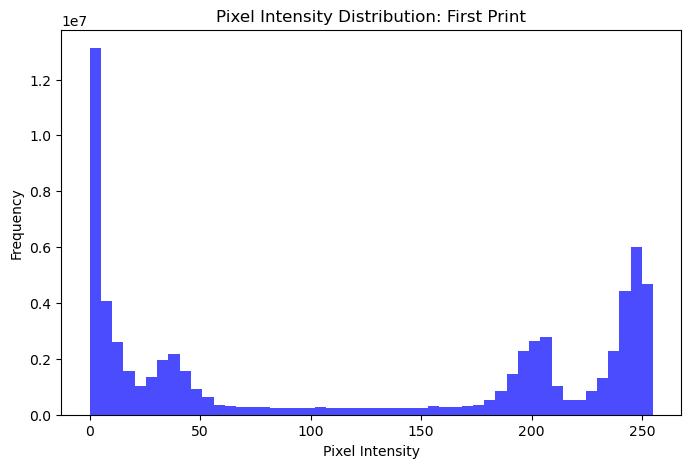

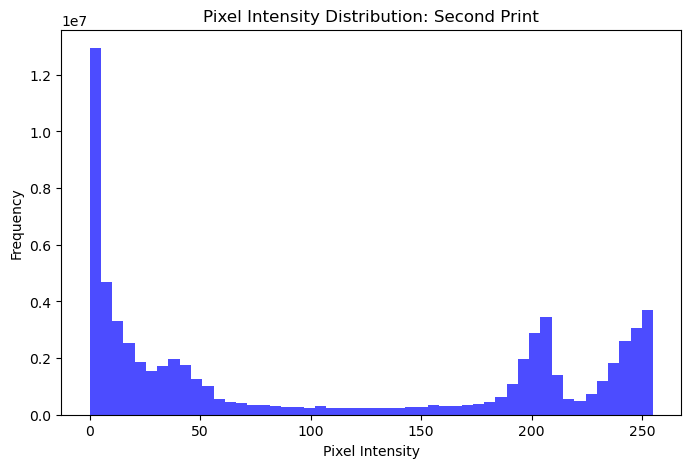

In [3]:
def compute_image_statistics(image_folder, title):
    pixel_values = []
    for img_name in os.listdir(image_folder)[:100]:  # Analyze only 100 images
        img_path = os.path.join(image_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        pixel_values.extend(img.flatten())

    plt.figure(figsize=(8, 5))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title(f"Pixel Intensity Distribution: {title}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

compute_image_statistics(first_print_dir, "First Print")
compute_image_statistics(second_print_dir, "Second Print")


In [4]:
def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Edge Detection (Sobel)
    edges = filters.sobel(img)
    edge_mean = np.mean(edges)

    # Texture Features (GLCM)
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]

    return [edge_mean, contrast, dissimilarity]


In [5]:
def process_dataset(image_folder, label, max_images=500):  # Limit to 500 images
    image_files = os.listdir(image_folder)[:max_images]
    features = [extract_features(os.path.join(image_folder, img)) for img in image_files]
    labels = [label] * len(image_files)
    return pd.DataFrame(features, columns=['Edge Mean', 'Contrast', 'Dissimilarity']), labels

# Process dataset
first_features, first_labels = process_dataset(first_print_dir, 0)
second_features, second_labels = process_dataset(second_print_dir, 1)

# Combine datasets
X = pd.concat([first_features, second_features], axis=0)
y = first_labels + second_labels

print("Dataset Shape:", X.shape)


Dataset Shape: (200, 3)


In [6]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Evaluate
y_pred = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


SVM Accuracy: 0.675
              precision    recall  f1-score   support

           0       0.67      0.76      0.71        21
           1       0.69      0.58      0.63        19

    accuracy                           0.68        40
   macro avg       0.68      0.67      0.67        40
weighted avg       0.68      0.68      0.67        40



In [7]:
# Image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 16  # Reduced for memory efficiency

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80-20 train-validation split
)

train_generator = datagen.flow_from_directory(
    extract_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    extract_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Build CNN Model
model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN Model
model.fit(train_generator, validation_data=val_generator, epochs=5)  # Reduce epochs to save RAM


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


C:\Users\jhasn\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\jhasn\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step - accuracy: 0.5071 - loss: 1.5132 - val_accuracy: 0.6500 - val_loss: 0.5809
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.7058 - loss: 0.5687 - val_accuracy: 0.9000 - val_loss: 0.4080
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.8844 - loss: 0.3694 - val_accuracy: 0.8500 - val_loss: 0.3127
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.9663 - loss: 0.2399 - val_accuracy: 0.8500 - val_loss: 0.2638
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.9787 - loss: 0.1223 - val_accuracy: 0.9500 - val_loss: 0.1453


In [10]:
import numpy as np

# Get true labels & predictions for CNN
y_true = val_generator.classes  # True labels from validation set
y_pred_probs = model.predict(val_generator)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute CNN metrics
cnn_precision = precision_score(y_true, y_pred)
cnn_recall = recall_score(y_true, y_pred)
cnn_f1 = f1_score(y_true, y_pred)

# Update results table
results_df.loc[1, "Precision"] = cnn_precision
results_df.loc[1, "Recall"] = cnn_recall
results_df.loc[1, "F1-Score"] = cnn_f1

# Display updated table
print("\nUpdated Model Performance Summary:")
print(results_df)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

Updated Model Performance Summary:
                                Model  Accuracy Precision    Recall  F1-Score
0        Support Vector Machine (SVM)     0.675    0.6875  0.578947  0.628571
1  Convolutional Neural Network (CNN)     0.950       0.5      0.55   0.52381
